# Étape 1: Préparation des données

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import pyodbc
from sklearn.preprocessing import LabelEncoder
# Paramètres de connexion à la base de données
server = 'DESKTOP-O7CGU5J\MSSQLSERVER2'
database = 'DW_HR_Projrct'
username = 'sa1'
password = 'sa@123@123'
driver = '{ODBC Driver 17 for SQL Server}'

# Chaîne de connexion
conn_str = f'DRIVER={driver};SERVER={server};DATABASE={database};UID={username};PWD={password}'

# Connectez-vous à la base de données
conn = pyodbc.connect(conn_str)

# Exécutez une requête SQL pour charger les données
sql_query = """
SELECT *
FROM dim_employees
"""
data = pd.read_sql(sql_query, conn)

# Assurez-vous de fermer la connexion après les opérations
conn.close()





C:\Users\khiar\Anaconda3\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [6]:
# Convertissez les colonnes de date en datetime, en gérant les valeurs manquantes si nécessaire
data['CONTRACT_START'] = pd.to_datetime(data['CONTRACT_START'], errors='coerce')
data['CONTRACT_END'] = pd.to_datetime(data['CONTRACT_END'], errors='coerce')

# Étape 2: Nettoyage des données

In [7]:
# Filtrer les données pour exclure les contrats sans date de fin connue
cleaned_data = data.dropna(subset=['CONTRACT_END'])

# Étape 2 : Créer la série temporelle des démissions



In [8]:
# Créer une série temporelle des démissions par année
resignations_per_year = cleaned_data['CONTRACT_END'].dt.year.value_counts().sort_index()


# Étape complémentaire : Division des données en ensembles d'entraînement et de test

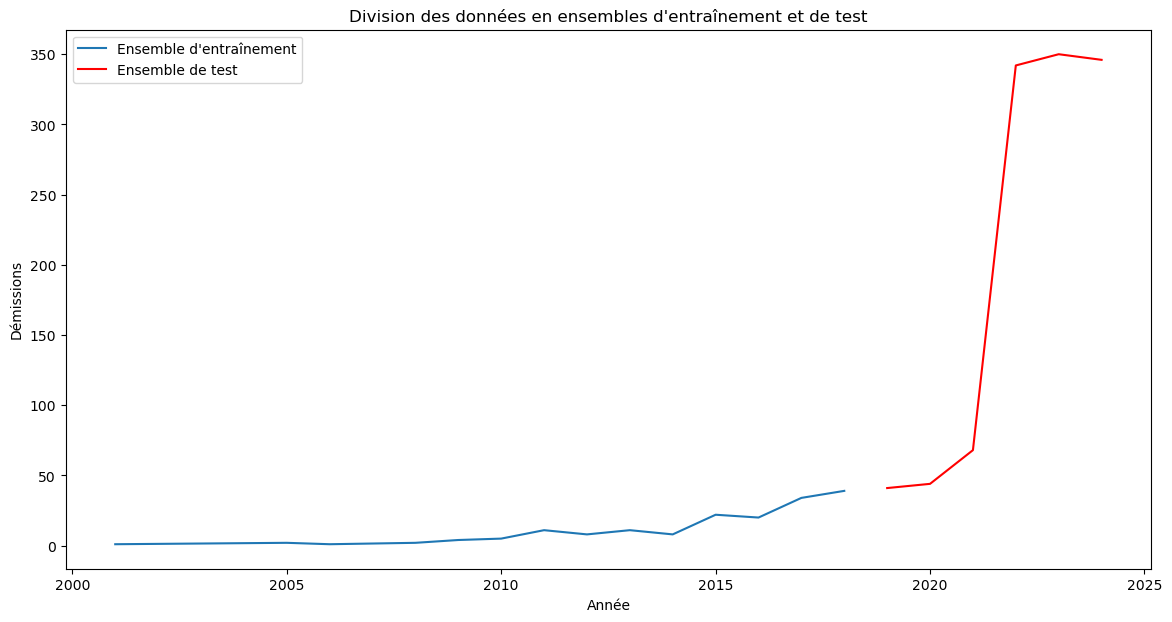

In [9]:
# Calculer l'indice pour la séparation
split_idx = int(len(resignations_per_year) * 0.7)

# Diviser les données en ensembles d'entraînement et de test
train_data = resignations_per_year.iloc[:split_idx]
test_data = resignations_per_year.iloc[split_idx:]

# Visualisation des données d'entraînement et de test
plt.figure(figsize=(14, 7))
plt.plot(train_data, label='Ensemble d\'entraînement')
plt.plot(test_data, label='Ensemble de test', color='red')
plt.title('Division des données en ensembles d\'entraînement et de test')
plt.xlabel('Année')
plt.ylabel('Démissions')
plt.legend()
plt.show()


# Étape 3 : Remplir les années manquantes

In [10]:
# Assurer une série temporelle continue en remplissant les années manquantes avec zéro
years = range(resignations_per_year.index.min(), resignations_per_year.index.max() + 1)
resignations_per_year = resignations_per_year.reindex(years, fill_value=0)


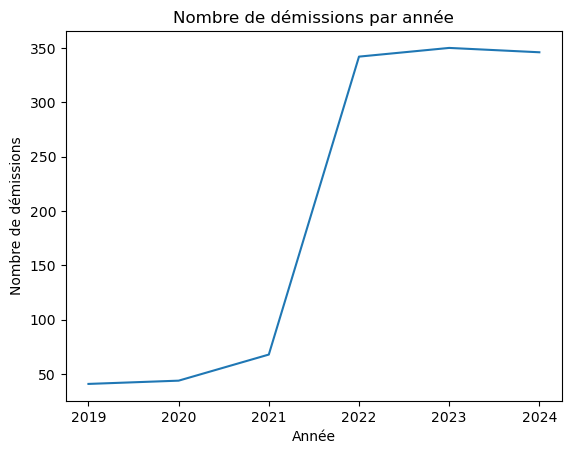

In [20]:
# Visualisation de la série des démissions
test_data.plot()
plt.xlabel('Année')
plt.ylabel('Nombre de démissions')
plt.title('Nombre de démissions par année')
plt.show()


# Étape 4: Analyse ACF et PACF

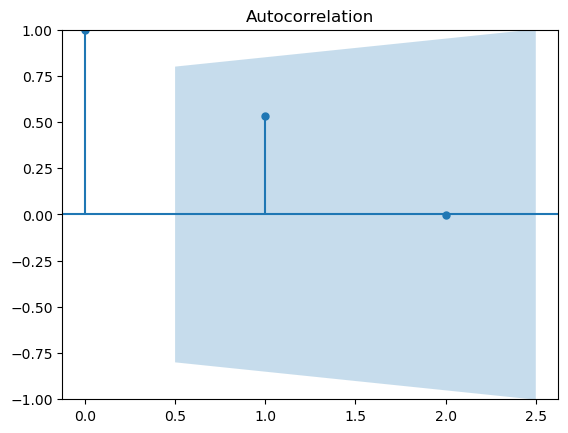

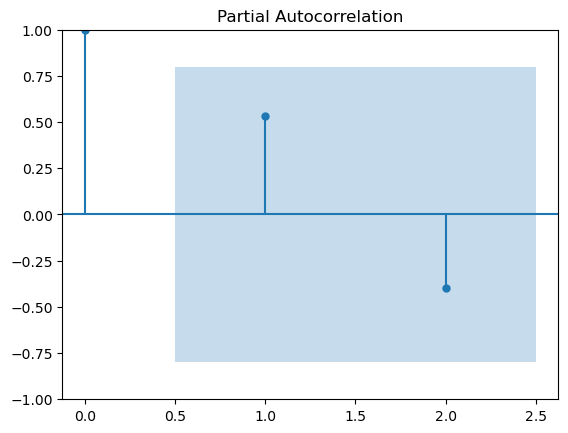

In [21]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Calcul du nombre de décalages (nlags) pour ACF et PACF
nlags = min(len(test_data) // 2 - 1, 40)  

# Visualisation de ACF et PACF
plot_acf(test_data, lags=nlags)
plot_pacf(test_data, lags=nlags, method='ywm')
plt.show()


# Étape 5: Créer et ajuster un modèle SARIMA

In [25]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Créer et ajuster un modèle SARIMA
sarima_model = SARIMAX(resignations_per_year, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_results = sarima_model.fit()

# Afficher le résumé des résultats du modèle
print(sarima_results.summary())


C:\Users\khiar\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                                     SARIMAX Results                                      
Dep. Variable:                       CONTRACT_END   No. Observations:                   24
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 -64.150
Date:                            Sun, 28 Apr 2024   AIC                            138.300
Time:                                    00:14:48   BIC                            140.289
Sample:                                         0   HQIC                           137.046
                                             - 24                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0352    499.789   7.04e-05      1.000    -979.532     979.603
ma.L1          0.0455    502.753   

C:\Users\khiar\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# Étape 5: Ajustement du modèle de lissage exponentiel

In [26]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Créer et ajuster un modèle de lissage exponentiel
hw_model = ExponentialSmoothing(
    resignations_per_year,
    trend='add',
    seasonal='add',
    seasonal_periods=12
)

hw_results = hw_model.fit()

# Afficher le résumé des résultats du modèle
print(hw_results.summary())

# Prédire les valeurs futures
hw_forecast = hw_results.forecast(steps=5)


                       ExponentialSmoothing Model Results                       
Dep. Variable:             CONTRACT_END   No. Observations:                   24
Model:             ExponentialSmoothing   SSE                          37846.765
Optimized:                         True   AIC                            208.718
Trend:                         Additive   BIC                            227.567
Seasonal:                      Additive   AICC                           345.518
Seasonal Periods:                    12   Date:                 Sun, 28 Apr 2024
Box-Cox:                          False   Time:                         00:14:58
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.9986490                alpha                 True
smoothing_trend          

# Étape 6: Diagnostic du modèle modèle de lissage exponentiel


# Histogramme des résidus :


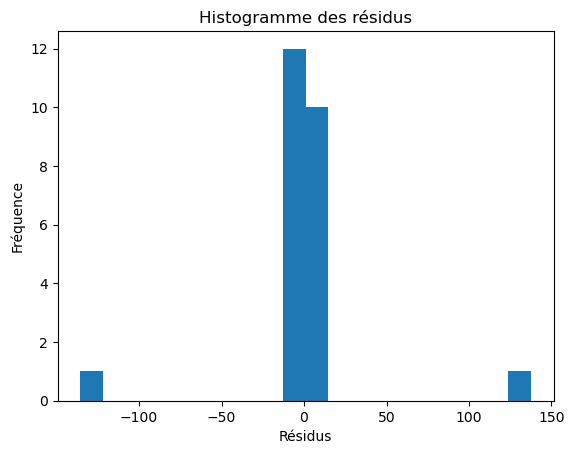

In [27]:
residus = resignations_per_year - hw_results.fittedvalues
plt.hist(residus, bins=20)
plt.title('Histogramme des résidus')
plt.xlabel('Résidus')
plt.ylabel('Fréquence')
plt.show()


# Graphique des résidus par rapport aux valeurs ajustées :

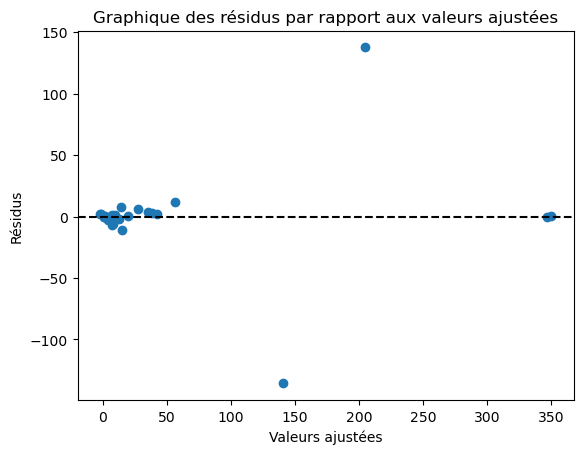

In [28]:
plt.scatter(hw_results.fittedvalues, residus)
plt.title('Graphique des résidus par rapport aux valeurs ajustées')
plt.xlabel('Valeurs ajustées')
plt.ylabel('Résidus')
plt.axhline(y=0, color='black', linestyle='--')
plt.show()


# Graphique de la fonction d'autocorrélation des résidus :

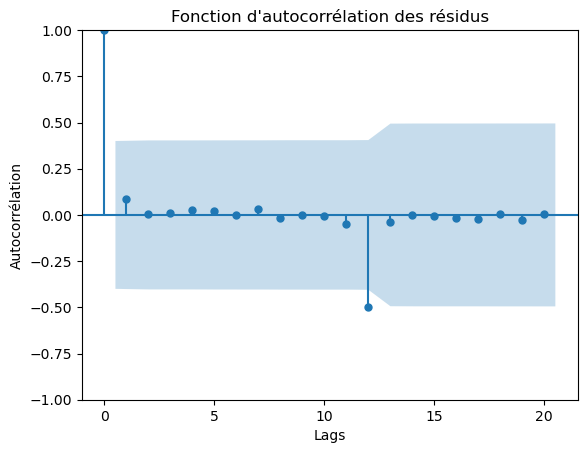

In [29]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(residus, lags=20)
plt.title('Fonction d\'autocorrélation des résidus')
plt.xlabel('Lags')
plt.ylabel('Autocorrélation')
plt.show()


# Étape 7: Prédictions futures

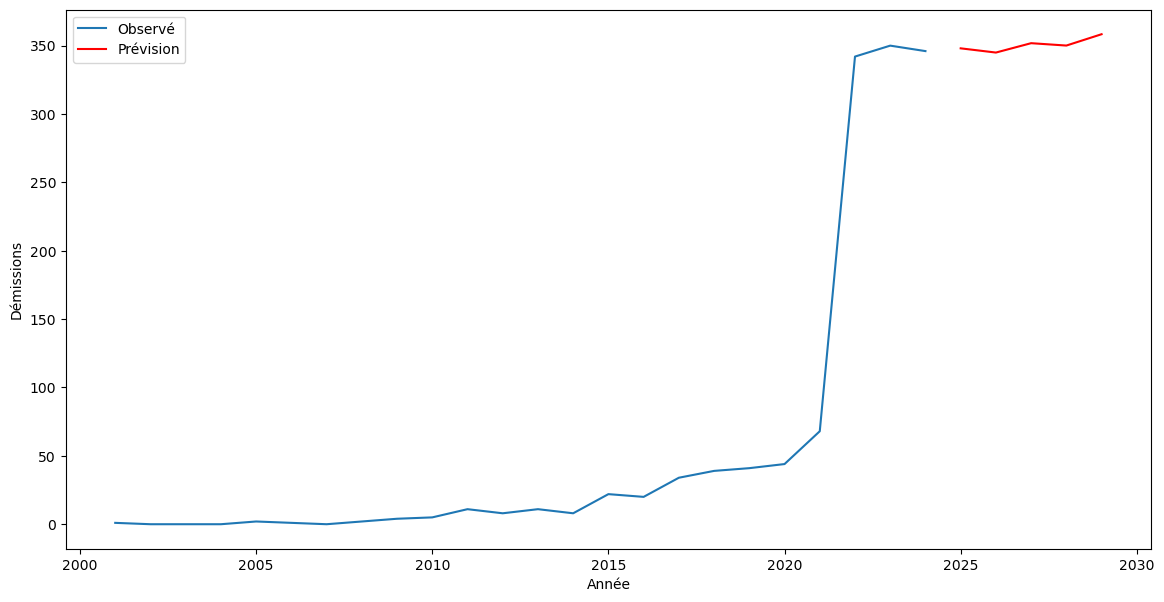

In [30]:
# Prédictions pour les années futures
steps = 5
hw_forecast = hw_results.forecast(steps=steps)

# Calculer les intervalles de confiance
alpha = 0.05  # Niveau de confiance à 95%
hw_forecast_ci = hw_forecast.to_frame(name='Prévision').assign(
    Inférieure=lambda x: hw_forecast - x.quantile(alpha / 2),
    Supérieure=lambda x: x.quantile(1 - alpha / 2) - hw_forecast
)

# Visualisation des prédictions
ax = resignations_per_year.plot(label='Observé', figsize=(14, 7))
hw_forecast.plot(ax=ax, label='Prévision', color='red')
ax.fill_between(hw_forecast_ci.index, hw_forecast - hw_forecast_ci['Inférieure'], hw_forecast + hw_forecast_ci['Supérieure'], color='k', alpha=.1)
ax.set_xlabel('Année')
ax.set_ylabel('Démissions')
plt.legend()
plt.show()


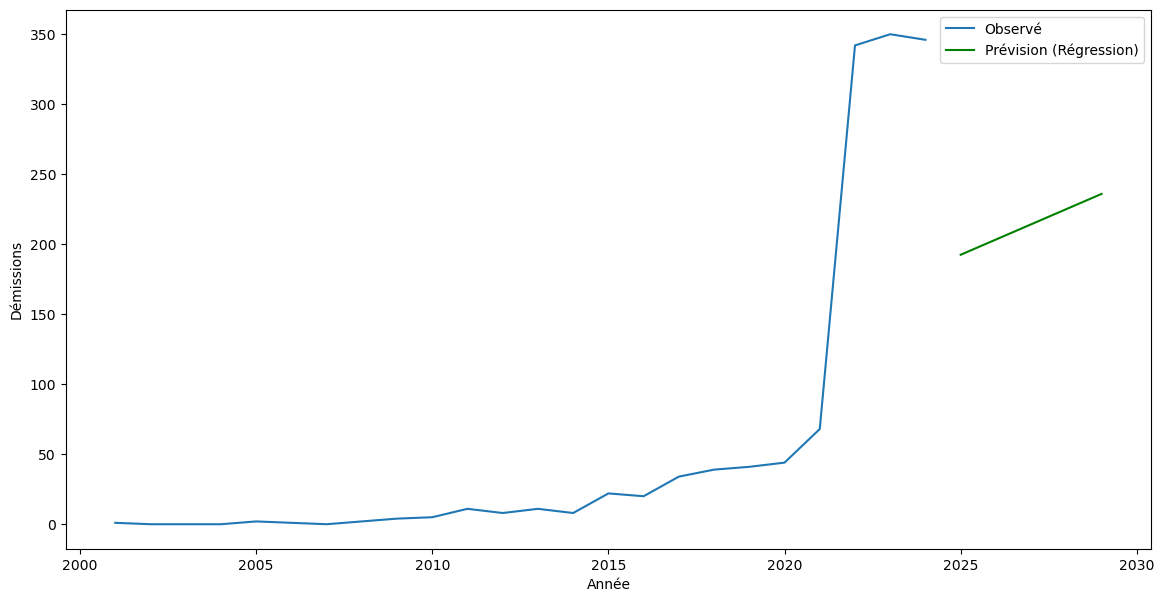

In [31]:
from sklearn.linear_model import LinearRegression

# Création d'un DataFrame pour la régression
regression_data = pd.DataFrame({'Année': resignations_per_year.index})
regression_data['Observé'] = resignations_per_year.values

# Création de la variable de temps pour la régression
regression_data['Temps'] = range(1, len(regression_data) + 1)

# Ajustement d'un modèle de régression linéaire
regression_model = LinearRegression()
regression_model.fit(regression_data[['Temps']], regression_data['Observé'])

# Prévisions de la régression pour les années futures
future_years = range(max(resignations_per_year.index) + 1, max(resignations_per_year.index) + 1 + steps)
future_data = pd.DataFrame({'Temps': range(len(resignations_per_year) + 1, len(resignations_per_year) + 1 + steps)})
future_predictions = regression_model.predict(future_data)

# Visualisation des prédictions de la régression
ax = resignations_per_year.plot(label='Observé', figsize=(14, 7))
plt.plot(future_years, future_predictions, label='Prévision (Régression)', color='green')
ax.set_xlabel('Année')
ax.set_ylabel('Démissions')
plt.legend()
plt.show()
